In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import geopandas as gpd
import pyproj
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from scipy import stats
from persiantools.jdatetime import JalaliDate
from scipy import stats
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

/home/aliqnbri/.conda/envs/quera-project/lib/python3.11/site-packages/optuna/study/_optimize.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
# Load data
divar_df = pd.read_csv('../DataSets/Divar.csv')

In [3]:
df = divar_df.copy()
original_shape = df.shape
print(f"Original dataset: {original_shape[0]:,} rows × {original_shape[1]} columns")

Original dataset: 1,000,000 rows × 61 columns


# =============================================================================
# DATA COLUMN DEFINITIONS
# =============================================================================


In [4]:
target_columns = ["price_value", "rent_value", "credit_value", "transformable_price"]

boolean_columns = [
    "rent_to_single",
    "has_business_deed",
    "has_balcony",
    "has_elevator",
    "has_electricity",
    "has_gas",
    "has_security_guard",
    "has_warehouse",
    "has_parking",
    "is_rebuilt",
    "has_water",
    "has_barbecue",
    "has_pool",
    "has_jacuzzi",
    "has_sauna",
    "rent_credit_transform",
]

numerical_columns = [
    "rent_value",
    "price_value",
    "credit_value",
    "transformable_credit",
    "transformed_credit",
    "transformable_rent",
    "transformed_rent",
    "land_size",
    "building_size",
    "floor",
    "rooms_count",
    "total_floors_count",
    "unit_per_floor",
    "construction_year",
    "regular_person_capacity",
    "extra_person_capacity",
    "cost_per_extra_person",
    "rent_price_on_regular_days",
    "rent_price_on_special_days",
    "rent_price_at_weekends",
    'construction_year'
]

price_columns = [
    "price_value",
    "rent_value",
    "credit_value",
    "transformable_price",
    "transformable_credit",
    "transformed_credit",
    "transformable_rent",
    "transformed_rent",
    "cost_per_extra_person",
    "rent_price_on_regular_days",
    "rent_price_on_special_days",
    "rent_price_at_weekends",
]

size_columns = ["land_size", "building_size"]
geo_columns = ["location_latitude", "location_longitude", "location_radius"]
categorical_columns = [
    "user_type",
    "rent_mode",
    "credit_mode",
    "cat2_slug",
    "cat3_slug",
    "city_slug",
    "deed_type",
    "building_direction",
    "floor_material",
    "property_type",
    "neighborhood_slug",
    "price_mode",
    "has_cooling_system",
    "has_heating_system",
    "has_restroom",
    "has_warm_water_provider",
    "rent_type",
]

In [5]:
for col in df.select_dtypes(include='object'):
    print(f"{col} has {len(df[col].unique()  ) >= 9} values")

cat2_slug has False values
cat3_slug has True values
city_slug has True values
neighborhood_slug has True values
created_at_month has True values
user_type has False values
description has True values
title has True values
rent_mode has False values
rent_to_single has False values
rent_type has False values
price_mode has False values
credit_mode has False values
rent_credit_transform has False values
transformable_price has False values
deed_type has False values
has_business_deed has False values
floor has True values
rooms_count has False values
total_floors_count has True values
unit_per_floor has True values
has_balcony has False values
has_elevator has False values
has_warehouse has False values
has_parking has False values
construction_year has True values
is_rebuilt has False values
has_water has False values
has_warm_water_provider has False values
has_electricity has False values
has_gas has False values
has_heating_system has True values
has_cooling_system has False values
h


# =============================================================================
# STEP 1: BASIC DATA CLEANING
# =============================================================================


In [6]:
# Drop irrelevant columns
drop_cols = ["Unnamed: 0", "title", "description"]
deleted_colums = df[drop_cols]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [7]:

# Convert target and price columns to numeric
df[target_columns] = df[target_columns].apply(lambda x: pd.to_numeric(x, errors='coerce'))
price_convert = df.columns.intersection(price_columns)
df[price_convert] = df[price_convert].apply(pd.to_numeric, errors="coerce")


In [8]:
# Convert specified money columns to numeric
price_convert = df.columns.intersection(price_columns)
df[price_convert] = df[price_convert].apply(pd.to_numeric, errors="coerce")

In [9]:
# Persian number conversion function
def convert_persian_numbers(text):
    if pd.isna(text):
        return text
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    english_digits = "0123456789"
    for p, e in zip(persian_digits, english_digits):
        text = str(text).replace(p, e)
    return text


# Apply Persian conversion to relevant columns
persian_cols = ["construction_year", "total_floors_count", "floor", "rooms_count"]
for col in persian_cols:
    if col in df.columns:
        df[col] = df[col].apply(convert_persian_numbers)

In [10]:
#  rooms count mapping
rooms_mapping = {
    "بدون اتاق": 0,
    "یک": 1,
    "دو": 2,
    "سه": 3,
    "چهار": 4,
    "پنج یا بیشتر": 5,
    "5+": 5,
    "استودیو": 0,
}
if "rooms_count" in df.columns:
    df["rooms_count"] = df["rooms_count"].map(rooms_mapping)
    df["rooms_count"] = pd.to_numeric(df["rooms_count"], errors="coerce")

In [11]:
# Construction year cleaning with validation
if "construction_year" in df.columns:
    df["construction_year"] = pd.to_numeric(
        df["construction_year"].str.extract(r"(\d+)")[0], errors="coerce"
    )

In [12]:
# Floor and building floors validation
numeric_replacements = {"30+": 31, "more_than_30": 31, "unselect": 1, "more_than_8": 9}
for col in ["floor", "total_floors_count", "extra_person_capacity", "unit_per_floor"]:
    if col in df.columns:
        df[col] = df[col].replace(numeric_replacements)
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [13]:
# Persian text mapping 
persian_mappings = {
    "user_type": {"مشاور املاک": "agent", "شخصی": "personal"},
    "rent_mode": {"مقطوع": "fixed", "مجانی": "free", "توافقی": "negotiable"},
    "price_mode": {"مقطوع": "fixed", "مجانی": "free", "توافقی": "negotiable"},
    "credit_mode": {"مقطوع": "fixed", "مجانی": "free", "توافقی": "negotiable"},
}

for col, mapping in persian_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

In [14]:
# Boolean column standardization
bool_map = {True: 1, False: 0, "true": 1, "false": 0, "yes": 1, "no": 0, "unselect": 0}
for col in boolean_columns:
    if col in df.columns:
        df[col] = df[col].map(bool_map).astype("Int8")

In [15]:
# Time-based features from Persian date - OPTIMIZED
if "created_at_month" in df.columns:
    # Convert to datetime efficiently
    df["created_at_month"] = pd.to_datetime(df["created_at_month"], errors="coerce")

    # Convert to JalaliDate and extract month directly
    df["shamsi_date"] = df["created_at_month"].apply(
        lambda x: JalaliDate(x) if pd.notna(x) else None
    )

    df["month"] = (
        df["shamsi_date"]
        .apply(lambda x: x.month if x is not None else None)
        .astype("Int8")
    )

    df["year"] = (
        df["shamsi_date"]
        .apply(lambda x: x.year if x is not None else None)
        .astype("Int16")
    )

    # Create season from month
    df["season"] = ((df["month"] - 1) // 3 + 1).astype("Int8")

    # Drop the original column and any temporary columns
    df.drop("created_at_month", axis=1, inplace=True)

# =============================================================================
# STEP 3:  OUTLIER DETECTION AND HANDLING
# =============================================================================

In [16]:
df_filterd = df

In [17]:
# Remove rows with invalid geographic coordinates (global bounds)
valid_geo_mask = df_filterd["location_latitude"].between(-90, 90) & df_filterd[
    "location_longitude"
].between(-180, 180)
df_filterd = df[valid_geo_mask]

In [18]:
# Download Iran boundaries directly
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
iran = world[world["ISO_A3"] == "IRN"]

In [19]:
# Convert your DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_filterd,
    geometry=gpd.points_from_xy(df_filterd["location_longitude"], df_filterd["location_latitude"]),
    crs="EPSG:4326",
)

# Perform spatial join to find points within Iran
points_in_iran = gpd.sjoin(gdf, iran, how="inner", predicate="within")
points_outside_iran = gdf[~gdf.index.isin(points_in_iran.index)]

# Return the filtered DataFrame (only points inside Iran)
df_filterd = points_in_iran[df_filterd.columns].copy()
print(f"Filtered DataFrame shape: {df.shape}")

Filtered DataFrame shape: (1000000, 61)


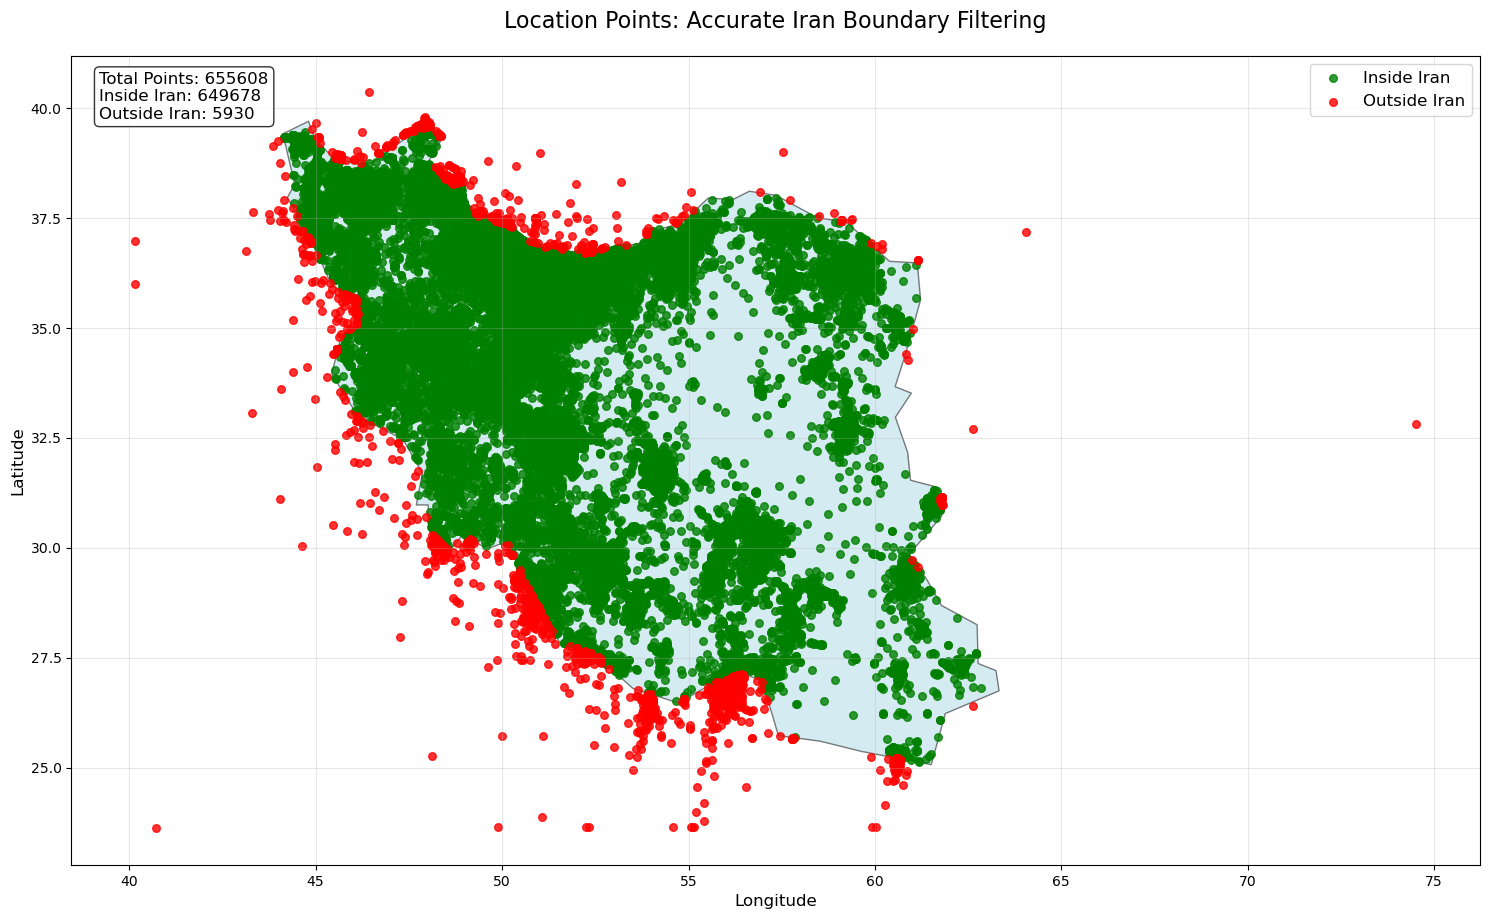

In [20]:

# Create visualization
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Iran with detailed boundaries
iran.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5, label="Iran")

# Plot points inside Iran
points_in_iran.plot(ax=ax, color="green", markersize=30, alpha=0.8, label="Inside Iran")

# Plot points outside Iran
points_outside_iran.plot(
    ax=ax, color="red", markersize=30, alpha=0.8, label="Outside Iran"
)

# Customize the plot
ax.set_title("Location Points: Accurate Iran Boundary Filtering", fontsize=16, pad=20)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend(prop={"size": 12})
ax.grid(True, alpha=0.3)

# Add statistics text box
stats_text = f"Total Points: {len(gdf)}\nInside Iran: {len(points_in_iran)}\nOutside Iran: {len(points_outside_iran)}"
ax.text(
    0.02,
    0.98,
    stats_text,
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    fontsize=12,
)

plt.tight_layout()
plt.show()


In [21]:

df_filterd = points_in_iran[df_filterd.columns]
print(f"Filtered DataFrame shape: {df_filterd.shape}")
print(f"Removed {len(points_outside_iran)} outliers (points outside Iran)")

Filtered DataFrame shape: (649678, 61)
Removed 5930 outliers (points outside Iran)


No points outside Iran found


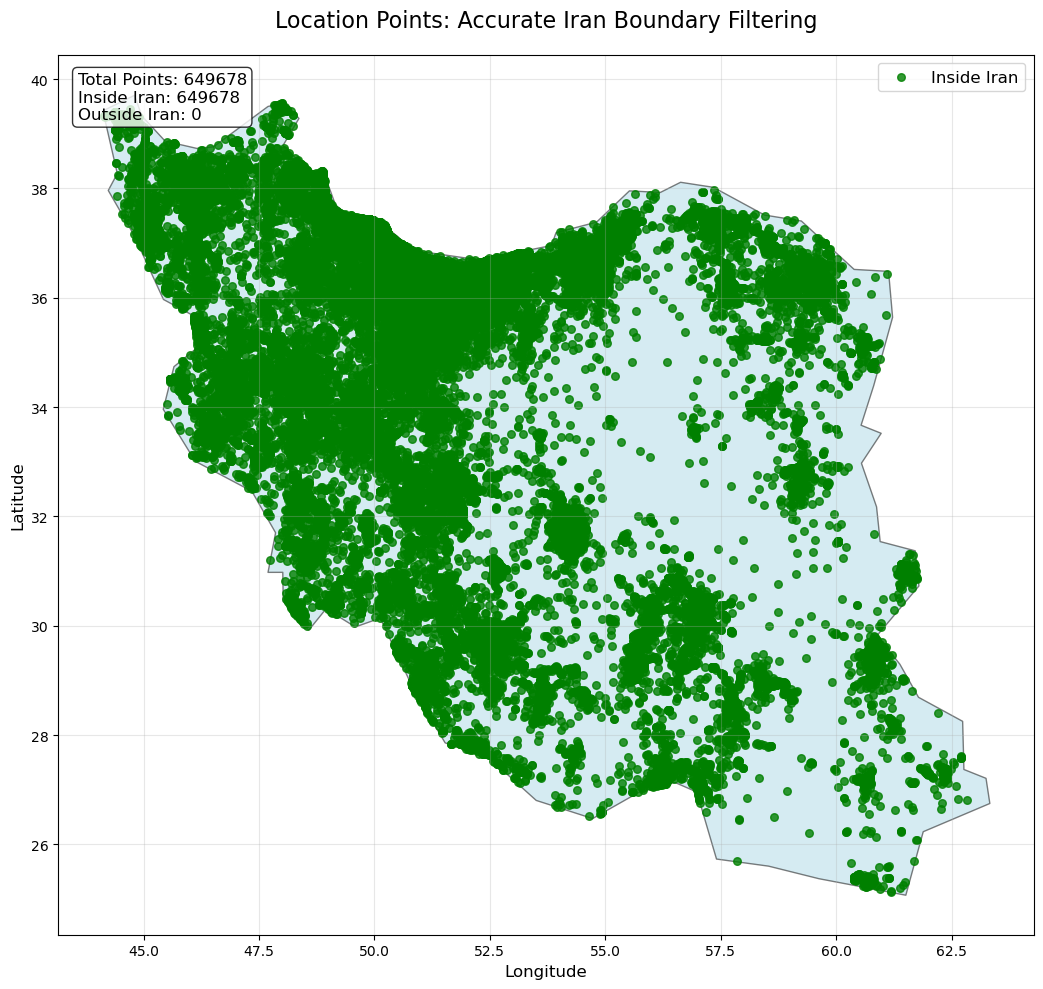

Filtered DataFrame shape: (649678, 61)


In [22]:
# Convert your DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_filterd,
    geometry=gpd.points_from_xy(df_filterd["location_longitude"], df_filterd["location_latitude"]),
    crs="EPSG:4326",
)

# Perform spatial join to find points within Iran
points_in_iran = gpd.sjoin(gdf, iran, how="inner", predicate="within")
points_outside_iran = gdf[~gdf.index.isin(points_in_iran.index)]

# Create visualization
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Iran with detailed boundaries
iran.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5, label="Iran")

# Plot points inside Iran
points_in_iran.plot(ax=ax, color="green", markersize=30, alpha=0.8, label="Inside Iran")

# Plot points outside Iran only if there are any
if not points_outside_iran.empty:
    points_outside_iran.plot(
        ax=ax, color="red", markersize=30, alpha=0.8, label="Outside Iran"
    )
else:
    print("No points outside Iran found")

# Customize the plot
ax.set_title("Location Points: Accurate Iran Boundary Filtering", fontsize=16, pad=20)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend(prop={"size": 12})
ax.grid(True, alpha=0.3)

# Add statistics text box
stats_text = f"Total Points: {len(gdf)}\nInside Iran: {len(points_in_iran)}\nOutside Iran: {len(points_outside_iran)}"
ax.text(
    0.02,
    0.98,
    stats_text,
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    fontsize=12,
)

plt.tight_layout()
plt.show()

# Return the filtered DataFrame (only points inside Iran)
df_iran = points_in_iran[df_filterd.columns].copy()
print(f"Filtered DataFrame shape: {df_iran.shape}")

In [23]:
# Outlier detection function
def apply_outlier_detection(df, price_columns, size_columns):
    outlier_summary = {}
    target_columns = list(set(price_columns + size_columns))

    for col in target_columns:
        # Check if column exists and has enough data
        if col not in df.columns or df[col].notna().sum() <= 100:
            continue

        # Ensure numeric type
        df[col] = pd.to_numeric(df[col], errors="coerce")
        valid_data = df[col].dropna()
        if valid_data.empty:
            continue

        data_length = len(valid_data)
        data_skew = abs(valid_data.skew())
        methods_to_use = ["iqr"]  # Always use IQR

        # Conditionally add methods
        if data_length > 10 and data_skew < 2:
            methods_to_use.append("zscore")
        if data_length > 50:
            methods_to_use.append("isolation")

        # Initialize outlier mask
        outliers = pd.Series(False, index=valid_data.index)

        # --- IQR Method ---
        if "iqr" in methods_to_use:
            Q1, Q3 = valid_data.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            iqr_mask = (valid_data < Q1 - 2.5 * IQR) | (valid_data > Q3 + 2.5 * IQR)
            outliers |= iqr_mask

        # --- Z-Score Method ---
        if "zscore" in methods_to_use and data_length > 3:
            z_scores = np.abs(stats.zscore(valid_data, nan_policy="omit"))
            zscore_mask = z_scores > 3.5
            outliers |= pd.Series(zscore_mask, index=valid_data.index)

        # --- Isolation Forest Method ---
        if "isolation" in methods_to_use:
            try:
                iso_model = IsolationForest(contamination=0.05, random_state=42)
                iso_mask = iso_model.fit_predict(valid_data.values.reshape(-1, 1)) == -1
                outliers |= pd.Series(iso_mask, index=valid_data.index)
            except Exception as e:
                print(f"{col}: Isolation Forest failed ({e})")

        # Outlier stats
        outlier_count = outliers.sum()
        outlier_percentage = (outlier_count / data_length) * 100

        # Save summary
        outlier_summary[col] = {
            "count": int(outlier_count),
            "percentage": round(outlier_percentage, 2),
            "methods_used": methods_to_use,
            "skewness": round(data_skew, 3),
            "sample_size": data_length,
        }

        # Cap outliers if significant
        if outlier_percentage > 1:
            lower_cap, upper_cap = df[col].quantile([0.01, 0.99])
            df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)

        # Print result
        print(
            f"{col}: {outlier_count} outliers ({outlier_percentage:.1f}%) using {methods_to_use} – capped"
        )

    return df, outlier_summary

In [24]:
df_filterd ,outlier_summary = apply_outlier_detection(df_filterd, price_columns, size_columns)
pd.DataFrame(outlier_summary).T

rent_price_on_special_days: 324 outliers (4.5%) using ['iqr', 'isolation'] – capped
transformable_credit: 12459 outliers (5.3%) using ['iqr', 'isolation'] – capped
rent_value: 15462 outliers (6.6%) using ['iqr', 'isolation'] – capped
transformed_rent: 2869 outliers (5.3%) using ['iqr', 'isolation'] – capped
land_size: 7732 outliers (6.9%) using ['iqr', 'isolation'] – capped
building_size: 56886 outliers (8.9%) using ['iqr', 'isolation'] – capped
rent_price_on_regular_days: 514 outliers (4.3%) using ['iqr', 'isolation'] – capped
cost_per_extra_person: 343 outliers (4.8%) using ['iqr', 'isolation'] – capped
transformed_credit: 3137 outliers (5.7%) using ['iqr', 'isolation'] – capped
transformable_price: 54670 outliers (23.5%) using ['iqr', 'zscore', 'isolation'] – capped
rent_price_at_weekends: 396 outliers (4.4%) using ['iqr', 'isolation'] – capped
credit_value: 12459 outliers (5.3%) using ['iqr', 'isolation'] – capped
price_value: 23309 outliers (6.3%) using ['iqr', 'isolation'] – capp

,count,percentage,methods_used,skewness,sample_size
rent_price_on_special_days,324,4.53,"[iqr, isolation]",59.564,7155
transformable_credit,12459,5.35,"[iqr, isolation]",194.362,232980
rent_value,15462,6.64,"[iqr, isolation]",249.983,232859
transformed_rent,2869,5.25,"[iqr, isolation]",19.048,54596
land_size,7732,6.86,"[iqr, isolation]",72.271,112725
building_size,56886,8.91,"[iqr, isolation]",66.179,638680
rent_price_on_regular_days,514,4.28,"[iqr, isolation]",79.562,12023
cost_per_extra_person,343,4.81,"[iqr, isolation]",84.31,7124
transformed_credit,3137,5.75,"[iqr, isolation]",233.657,54596
transformable_price,54670,23.46,"[iqr, zscore, isolation]",1.253,233071


In [25]:
df_filterd.shape

(649678, 61)

# =============================================================================
# STEP 4: MISSING VALUE IMPUTATION
# =============================================================================

In [26]:

# Assuming df_filterd and boolean_columns are defined
features = df_filterd.drop(columns=boolean_columns).copy()

# Encode categorical columns
for col in features.select_dtypes('object').columns:
    features[col] = features[col].astype('category').cat.codes


# Fill numeric NaNs
for col in price_columns:
    features[col] = features[col].fillna(features[col].median())


non_continues_numerical = set(numerical_columns) - set(price_columns)
# Fill numeric NaNs
for col in non_continues_numerical:
    features[col] = features[col].fillna(features[col].mode()[0])   
    

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
    
features.shape    
    


(649678, 45)

In [27]:
# Simple imputation for low missing (<5%) numerical columns
missing_analysis = df_filterd.isnull().sum() / len(df) * 100

low_missing = missing_analysis[missing_analysis <= 5].index.tolist()
medium_missing = missing_analysis[
    (missing_analysis > 5) & (missing_analysis <= 30)
].index.tolist()
high_missing = missing_analysis[missing_analysis > 30].index.tolist()

print(f"Low missing (<5%): {len(low_missing)} columns")
print(f"Medium missing (5-30%): {len(medium_missing)} columns")
print(f"High missing (>30%): {len(high_missing)} columns")

Low missing (<5%): 10 columns
Medium missing (5-30%): 9 columns
High missing (>30%): 42 columns


In [28]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Dictionary to store best parameters for each target
best_params_dict = {}

for target in boolean_columns:
    print(f"\nOptimizing: {target}")

    mask_train = df_filterd[target].notna()
    if mask_train.sum() == 0:
        continue

    X_train, y_train = features_scaled[mask_train], df_filterd.loc[mask_train, target].astype(int)

    # Define parameter search space for Bayesian optimization
    param_space = {
        'n_estimators': Integer(10, 100),  # Wider range but smarter sampling
        'learning_rate': Real(0.01, 0.1, prior='log-uniform')  # Log scale for better exploration
    }

    # Bayesian optimization - much more efficient!
    bayes_search = BayesSearchCV(
        LGBMClassifier(objective='binary', random_state=42, verbose=-1),
        param_space,
        n_iter=15,  # Only 15 evaluations vs 9 in grid search, but much smarter
        cv=3,
        scoring='accuracy',
        n_jobs=1,  #to avoid nested parallelism issues
        random_state=42,
        verbose=0
    )

    bayes_search.fit(X_train, y_train)

    print(f"Best parameters: {bayes_search.best_params_}")
    print(f"Best CV accuracy: {bayes_search.best_score_:.2f}")
    print(f"Total evaluations: {len(bayes_search.cv_results_['mean_test_score'])}")

    # Store best parameters for this target
    best_params_dict[target] = bayes_search.best_params_


Optimizing: rent_to_single
Best parameters: OrderedDict([('learning_rate', 0.02571011142608906), ('n_estimators', 75)])
Best CV accuracy: 0.83
Total evaluations: 15

Optimizing: has_business_deed
Best parameters: OrderedDict([('learning_rate', 0.1), ('n_estimators', 35)])
Best CV accuracy: 0.63
Total evaluations: 15

Optimizing: has_balcony
Best parameters: OrderedDict([('learning_rate', 0.1), ('n_estimators', 100)])
Best CV accuracy: 0.85
Total evaluations: 15

Optimizing: has_elevator
Best parameters: OrderedDict([('learning_rate', 0.1), ('n_estimators', 100)])
Best CV accuracy: 0.90
Total evaluations: 15

Optimizing: has_electricity
Best parameters: OrderedDict([('learning_rate', 0.04140753317701223), ('n_estimators', 80)])
Best CV accuracy: 0.88
Total evaluations: 15

Optimizing: has_gas
Best parameters: OrderedDict([('learning_rate', 0.09025639567934764), ('n_estimators', 73)])
Best CV accuracy: 0.88
Total evaluations: 15

Optimizing: has_security_guard
Best parameters: OrderedDi

In [29]:
for target in boolean_columns:
    print(f"\nTraining Model for: {target}")

    mask_train = df_filterd[target].notna()
  
    X_train, y_train = features_scaled[mask_train], df_filterd.loc[mask_train, target].astype(int)

    # Get best parameters for this target
    best_params = best_params_dict.get(target, {})

    # Train final model with best parameters and GPU
    best_model = LGBMClassifier(
        objective="binary",
        random_state=42,
        verbose=-1,
        device="gpu",  # Force GPU usage
        gpu_platform_id=0,  # GPU platform ID
        gpu_device_id=0,  # GPU device ID
        **best_params,
    )

    # Split for validation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    best_model.fit(X_tr, y_tr)

    # Validation accuracy
    val_acc = accuracy_score(y_val, best_model.predict(X_val))
    print(f"Validation Accuracy: {val_acc * 100:.2f}%")

    # Fill missing values
    mask_missing = df_filterd[target].isna()
    if mask_missing.any():
        df_filterd.loc[mask_missing, target] = best_model.predict(features[mask_missing])

    print(f"Filled {mask_missing.sum()} missing values for {target}")


Training Model for: rent_to_single
Validation Accuracy: 0.00%
Filled 649674 missing values for rent_to_single

Training Model for: has_business_deed
Validation Accuracy: 62.69%
Filled 626733 missing values for has_business_deed

Training Model for: has_balcony
Validation Accuracy: 85.79%
Filled 305832 missing values for has_balcony

Training Model for: has_elevator
Validation Accuracy: 89.90%
Filled 283989 missing values for has_elevator

Training Model for: has_electricity
Validation Accuracy: 87.99%
Filled 625070 missing values for has_electricity

Training Model for: has_gas
Validation Accuracy: 87.70%
Filled 625080 missing values for has_gas

Training Model for: has_security_guard
Validation Accuracy: 92.46%
Filled 626267 missing values for has_security_guard

Training Model for: has_warehouse
Validation Accuracy: 82.68%
Filled 171256 missing values for has_warehouse

Training Model for: has_parking
Validation Accuracy: 84.03%
Filled 171256 missing values for has_parking

Training

In [30]:
# Separate numerical columns into continuous and discrete
continuous = (
    [
        "land_size",
        "building_size",
        "transformable_credit",
        "transformed_credit",
        "transformable_rent",
        "transformed_rent",
        "cost_per_extra_person",
        "rent_price_on_regular_days",
        "rent_price_on_special_days",
        "rent_price_at_weekends",
    ]
    + price_columns
    + target_columns
)

continuous_cols = set(continuous)

discrete_cols = [
    "floor",
    "rooms_count",
    "total_floors_count",
    "unit_per_floor",
    "regular_person_capacity",
    "extra_person_capacity",
    "construction_year",
    "month",
    "year",
    "season",
]



# Prepare features for continuous imputation (excluding target variables)
feature_cols_continuous = [
    col for col in df_filterd.columns if col not in target_columns
]

# Create feature matrix for continuous imputation
X_continuous = df_filterd[feature_cols_continuous].copy()

# Encode categorical variables for model training
le_dict_continuous = {}
for col in X_continuous.select_dtypes(include=["object"]).columns:
    le_dict_continuous[col] = LabelEncoder()
    X_continuous[col] = le_dict_continuous[col].fit_transform(
        X_continuous[col].astype(str)
    )


# Fill any remaining NaN values temporarily for model training
X_continuous_filled = X_continuous.fillna(X_continuous.median())

# Scale features
scaler_continuous = StandardScaler()
X_continuous_scaled = scaler_continuous.fit_transform(X_continuous_filled)

In [31]:

# Impute each continuous column
for target_col in continuous_cols:
    print(f"\nProcessing: {target_col}")
    
    # Check missing values
    missing_mask = df_filterd[target_col].isna()
    missing_count = missing_mask.sum()
    
    if missing_count == 0:
        print(f"  No missing values in {target_col}")
        continue
        
    print(f"  Missing values: {missing_count} ({missing_count/len(df_filterd)*100:.1f}%)")
    
    # Prepare training data
    train_mask = df_filterd[target_col].notna()
    if train_mask.sum() < 50:
        print(f"  Too few samples, using median imputation")
        df_filterd.loc[missing_mask, target_col] = df_filterd[target_col].median()
        continue
    
    X_train = X_continuous_scaled[train_mask]
    y_train = df_filterd.loc[train_mask, target_col]
    X_missing = X_continuous_scaled[missing_mask]
    
    # Train LGBM model for imputation
    lgbm_continuous = LGBMRegressor(
        device="gpu",  # Force GPU usage
        gpu_platform_id=0,  # GPU platform ID
        gpu_device_id=0,  # GPU device ID
        n_estimators=50,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    )
    
    # Cross-validation score
    cv_scores = cross_val_score(lgbm_continuous, X_train, y_train, cv=3, 
                               scoring='neg_mean_absolute_error')
    mean_score = -cv_scores.mean()
    print(f"  Cross-validation MAE: {mean_score:.4f}")
    
    # Train final model
    lgbm_continuous.fit(X_train, y_train)
    
    # Predict missing values
    predictions = lgbm_continuous.predict(X_missing)
    df_filterd.loc[missing_mask, target_col] = predictions
    
    print(f"  Imputed {missing_count} values for {target_col}")



Processing: rent_price_on_special_days
  Missing values: 642523 (98.9%)
  Cross-validation MAE: 10833.1029
  Imputed 642523 values for rent_price_on_special_days

Processing: transformable_price
  Missing values: 416607 (64.1%)
  Cross-validation MAE: 0.0036
  Imputed 416607 values for transformable_price

Processing: transformable_credit
  Missing values: 416698 (64.1%)
  Cross-validation MAE: 2263605.7684
  Imputed 416698 values for transformable_credit

Processing: land_size
  Missing values: 536953 (82.6%)
  Cross-validation MAE: 1.5000
  Imputed 536953 values for land_size

Processing: transformed_rent
  Missing values: 595082 (91.6%)
  Cross-validation MAE: 79079.9761
  Imputed 595082 values for transformed_rent

Processing: rent_value
  Missing values: 416819 (64.2%)
  Cross-validation MAE: 82926.8774
  Imputed 416819 values for rent_value

Processing: building_size
  Missing values: 10998 (1.7%)
  Cross-validation MAE: 2.9569
  Imputed 10998 values for building_size

Processin

In [32]:

print("\n--- Imputing Discrete Numerical Values ---")

# For discrete numerical values, we'll use classification approach
for target_col in discrete_cols:
    print(f"\nProcessing: {target_col}")
    
    missing_mask = df_filterd[target_col].isna()
    missing_count = missing_mask.sum()
    
    if missing_count == 0:
        print(f"  No missing values in {target_col}")
        continue
        
    print(f"  Missing values: {missing_count} ({missing_count/len(df_filterd)*100:.1f}%)")
    
    # For discrete values, use mode if few missing values
    if missing_count / len(df_filterd) < 0.05:
        mode_value = df_filterd[target_col].mode()
        if len(mode_value) > 0:
            df_filterd.loc[missing_mask, target_col] = mode_value[0]
            print(f"  Used mode imputation: {mode_value[0]}")
        continue
    
    # For more missing values, use ML approach
    train_mask = df_filterd[target_col].notna()
    if train_mask.sum() < 50:
        mode_value = df_filterd[target_col].mode()
        if len(mode_value) > 0:
            df_filterd.loc[missing_mask, target_col] = mode_value[0]
            print(f"  Used mode imputation (insufficient data): {mode_value[0]}")
        continue
    
    X_train = X_continuous_scaled[train_mask]
    y_train = df_filterd.loc[train_mask, target_col].astype(int)
    X_missing = X_continuous_scaled[missing_mask]
    
    # Use classifier for discrete values
    lgbm_discrete = LGBMClassifier(
        device="gpu",  # Force GPU usage
        gpu_platform_id=0,  # GPU platform ID
        gpu_device_id=0,  # GPU device ID
        n_estimators=50,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    )
    
    # Cross-validation score
    try:
        cv_scores = cross_val_score(lgbm_discrete, X_train, y_train, cv=3, 
                                   scoring='accuracy')
        mean_accuracy = cv_scores.mean()
        print(f"  Cross-validation Accuracy: {mean_accuracy:.3f}")
        
        # Train and predict
        lgbm_discrete.fit(X_train, y_train)
        predictions = lgbm_discrete.predict(X_missing)
        df_filterd.loc[missing_mask, target_col] = predictions
        
        print(f"  Imputed {missing_count} values for {target_col}")
        
    except Exception as e:
        # Fallback to mode
        mode_value = df_filterd[target_col].mode()
        if len(mode_value) > 0:
            df_filterd.loc[missing_mask, target_col] = mode_value[0]
            print(f"  Used mode imputation (error): {mode_value[0]}")



--- Imputing Discrete Numerical Values ---

Processing: floor
  Missing values: 283989 (43.7%)


[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .



  Cross-validation Accuracy: nan
  Imputed 283989 values for floor

Processing: rooms_count
  Missing values: 95147 (14.6%)
  Cross-validation Accuracy: 1.000
  Imputed 95147 values for rooms_count

Processing: total_floors_count
  Missing values: 428547 (66.0%)


[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .



  Used mode imputation (error): 4.0

Processing: unit_per_floor
  Missing values: 430248 (66.2%)
  Cross-validation Accuracy: 1.000
  Imputed 430248 values for unit_per_floor

Processing: regular_person_capacity
  Missing values: 630902 (97.1%)
  Cross-validation Accuracy: 0.201
  Imputed 630902 values for regular_person_capacity

Processing: extra_person_capacity
  Missing values: 634308 (97.6%)
  Cross-validation Accuracy: 0.319
  Imputed 634308 values for extra_person_capacity

Processing: construction_year
  Missing values: 114016 (17.5%)


[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.right_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 862 .



  Used mode imputation (error): 1403.0

Processing: month
  No missing values in month

Processing: year
  No missing values in year

Processing: season
  No missing values in season


[LightGBM] [Fatal] Check failed: (best_split_info.right_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 862 .



In [33]:

for target_col in categorical_columns:
    print(f"\nProcessing: {target_col}")
    
    missing_mask = df_filterd[target_col].isna()
    missing_count = missing_mask.sum()
    
    if missing_count == 0:
        print(f"  No missing values in {target_col}")
        continue
        
    print(f"  Missing values: {missing_count} ({missing_count/len(df_filterd)*100:.1f}%)")
    
    # For categorical values with few missing, use mode
    if missing_count / len(df_filterd) < 0.05:
        mode_value = df_filterd[target_col].mode()
        if len(mode_value) > 0:
            df_filterd.loc[missing_mask, target_col] = mode_value[0]
            print(f"  Used mode imputation: {mode_value[0]}")
        continue
    
    # For more missing values, use ML approach
    train_mask = df_filterd[target_col].notna()
    if train_mask.sum() < 100:
        mode_value = df_filterd[target_col].mode()
        if len(mode_value) > 0:
            df_filterd.loc[missing_mask, target_col] = mode_value[0]
            print(f"  Used mode imputation (insufficient data): {mode_value[0]}")
        continue
    
    # Prepare data for categorical prediction
    X_train = X_continuous_scaled[train_mask]
    y_train = df_filterd.loc[train_mask, target_col]
    X_missing = X_continuous_scaled[missing_mask]
    
    # Encode target variable
    le_target = LabelEncoder()
    y_train_encoded = le_target.fit_transform(y_train.astype(str))
    
    # Train classifier
    lgbm_categorical = LGBMClassifier(
        device="gpu",  # Force GPU usage
        gpu_platform_id=0,  # GPU platform ID
        gpu_device_id=0,  # GPU device ID
        n_estimators=50,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    )
    
    try:
        # Cross-validation
        cv_scores = cross_val_score(lgbm_categorical, X_train, y_train_encoded, cv=3, 
                                   scoring='accuracy')
        mean_accuracy = cv_scores.mean()
        print(f"  Cross-validation Accuracy: {mean_accuracy:.3f}")
        
        if mean_accuracy > 0.3:  # Only use ML if accuracy is reasonable
            lgbm_categorical.fit(X_train, y_train_encoded)
            predictions_encoded = lgbm_categorical.predict(X_missing)
            predictions = le_target.inverse_transform(predictions_encoded)
            df_filterd.loc[missing_mask, target_col] = predictions
            print(f"  Imputed {missing_count} values using ML")
        else:
            # Use mode if accuracy is too low
            mode_value = df_filterd[target_col].mode()
            if len(mode_value) > 0:
                df_filterd.loc[missing_mask, target_col] = mode_value[0]
                print(f"  Used mode imputation (low accuracy): {mode_value[0]}")
            
    except Exception as e:
        # Fallback to mode
        mode_value = df_filterd[target_col].mode()
        if len(mode_value) > 0:
            df_filterd.loc[missing_mask, target_col] = mode_value[0]
            print(f"  Used mode imputation (error): {mode_value[0]}")



Processing: user_type
  Missing values: 482062 (74.2%)
  Cross-validation Accuracy: 1.000
  Imputed 482062 values using ML

Processing: rent_mode
  Missing values: 416585 (64.1%)
  Cross-validation Accuracy: 1.000
  Imputed 416585 values using ML

Processing: credit_mode
  Missing values: 416585 (64.1%)
  Cross-validation Accuracy: 1.000
  Imputed 416585 values using ML

Processing: cat2_slug
  No missing values in cat2_slug

Processing: cat3_slug
  Missing values: 1 (0.0%)
  Used mode imputation: apartment-sell

Processing: city_slug
  No missing values in city_slug

Processing: deed_type
  Missing values: 472049 (72.7%)


[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .



  Used mode imputation (error): single_page

Processing: building_direction
  Missing values: 418061 (64.3%)
  Cross-validation Accuracy: 1.000
  Imputed 418061 values using ML

Processing: floor_material
  Missing values: 362744 (55.8%)
  Cross-validation Accuracy: 1.000
  Imputed 362744 values using ML

Processing: property_type
  Missing values: 631064 (97.1%)
  Cross-validation Accuracy: 1.000
  Imputed 631064 values using ML

Processing: neighborhood_slug
  Missing values: 357211 (55.0%)
  Cross-validation Accuracy: 0.030
  Used mode imputation (low accuracy): poonak

Processing: price_mode
  Missing values: 278342 (42.8%)


[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .



  Used mode imputation (error): fixed

Processing: has_cooling_system
  Missing values: 398815 (61.4%)
  Cross-validation Accuracy: 1.000


[LightGBM] [Fatal] Check failed: (best_split_info.right_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 862 .



  Used mode imputation (error): water_cooler

Processing: has_heating_system
  Missing values: 385510 (59.3%)
  Cross-validation Accuracy: 1.000
  Imputed 385510 values using ML

Processing: has_restroom
  Missing values: 362495 (55.8%)


[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .

[LightGBM] [Fatal] Check failed: (best_split_info.left_count) > (0) at /__w/1/s/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .



  Used mode imputation (error): squat_seat

Processing: has_warm_water_provider
  Missing values: 380257 (58.5%)
  Cross-validation Accuracy: 1.000
  Imputed 380257 values using ML

Processing: rent_type
  Missing values: 585503 (90.1%)
  Cross-validation Accuracy: 0.999
  Imputed 585503 values using ML


In [34]:

for col in price_columns:
    if col in df_filterd.columns and df_filterd[col].isnull().sum() > 0:
        median_val = df_filterd[col].median()
        df_filterd[col] = df_filterd[col].fillna(median_val)
        print(f"✓ {col}: filled {df_filterd[col].isnull().sum()} missing values with median {median_val:.2f}")

# =============================================================================
# STEP 5:  FEATURE ENGINEERING
# =============================================================================

In [50]:
df_filterd.drop('location_radius' , inplace=True)

KeyError: "['location_radius'] not found in axis"

In [35]:
if "construction_year" in df_filterd.columns:
    current_year = 1404
    df_filterd["building_age"] = (current_year - df_filterd["construction_year"]).clip(
        0, 35
    )

    # Linear scoring: 0 years = score 5, 35 years = score 0
    df_filterd["bulding_age_score"] = (5 * (1 - df_filterd["building_age"] / 35)).round(
        1
    )

In [36]:
# Price per square meter
if (
    "transformable_price" in df_filterd.columns
    and "building_size" in df_filterd.columns
):
    df_filterd["price_per_sqm"] = df_filterd["transformable_price"] / (
        df_filterd["building_size"] + 1
    )

In [37]:
# Amenities scoring system
luxury_amenities = ["has_pool", "has_jacuzzi", "has_sauna", "has_barbecue"]
comfort_amenities = ["has_elevator", "has_parking", "has_balcony", "has_warehouse"]
basic_amenities = ["has_water", "has_gas", "has_electricity"]
security_amenities = ["has_security_guard"]
all_amenities = (
    luxury_amenities + comfort_amenities + basic_amenities + security_amenities
)
available_amenities = [col for col in all_amenities if col in df_filterd.columns]

In [38]:
# Calculate amenity_score directly without intermediate columns
df_filterd["amenity_score"] = 0

# Luxury amenities (weight: 4)
available_luxury = [col for col in luxury_amenities if col in df_filterd.columns]
if available_luxury:
    df_filterd["amenity_score"] += df_filterd[available_luxury].sum(axis=1) * 4

# Comfort amenities (weight: 3)
available_comfort = [col for col in comfort_amenities if col in df_filterd.columns]
if available_comfort:
    df_filterd["amenity_score"] += df_filterd[available_comfort].sum(axis=1) * 3

# Basic amenities (weight: 1)
available_basic = [col for col in basic_amenities if col in df_filterd.columns]
if available_basic:
    df_filterd["amenity_score"] += df_filterd[available_basic].sum(axis=1) * 1

# Security amenities (weight: 2)
available_security = [col for col in security_amenities if col in df_filterd.columns]
if available_security:
    df_filterd["amenity_score"] += df_filterd[available_security].sum(axis=1) * 2

df_filterd["amenity_score"] = df_filterd["amenity_score"].astype("int16")

In [39]:

# UTM coordinates
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32639", always_xy=True)
easting, northing = transformer.transform(df["location_longitude"].values, df["location_latitude"].values)
df["utm_x"] = easting
df["utm_y"] = northing

# =============================================================================
# STEP : DATA TYPE OPTIMIZATION
# =============================================================================


In [40]:
# Optimize data types
for col in df_filterd.columns:
    if df_filterd[col].dtype == "float64":
        df_filterd[col] = pd.to_numeric(df_filterd[col], downcast="float")
    elif df_filterd[col].dtype == "int64":
        df_filterd[col] = pd.to_numeric(df_filterd[col], downcast="integer")

print(f"Final dataset shape: {df_filterd.shape}")


Final dataset shape: (649678, 65)


In [41]:
#Check missing values for all columns
missing_values = df_filterd.isnull().sum()
missing_percentage = (df_filterd.isnull().sum() / len(df_filterd)) * 100

# Create missing values summary
missing_summary = pd.DataFrame(
    {"missing_count": missing_values, "missing_percentage": missing_percentage.round(2)}
)

# Show columns with missing values
columns_with_missing = missing_summary[missing_summary["missing_count"] > 0]
print("Columns with missing values:")
print(columns_with_missing.sort_values("missing_percentage", ascending=False))

# Show columns without missing values
columns_without_missing = missing_summary[missing_summary["missing_count"] == 0]
print(f"\nColumns without missing values: {len(columns_without_missing)}")

# Total summary
print(f"\nTotal columns: {len(df_filterd.columns)}")
print(f"Columns with missing values: {len(columns_with_missing)}")
print(f"Columns without missing values: {len(columns_without_missing)}")
print(
    f"Overall missing percentage: {df_filterd.isnull().sum().sum() / (len(df_filterd) * len(df_filterd.columns)) * 100:.2f}%"
)


Columns with missing values:
                 missing_count  missing_percentage
location_radius         410265               63.15

Columns without missing values: 64

Total columns: 65
Columns with missing values: 1
Columns without missing values: 64
Overall missing percentage: 0.97%


In [42]:
df_filterd.to_pickle("../DataSets/clean_divar_data.pkl")
df_filterd.to_csv("../DataSets/clean_divar_data.csv")

print("Clean data saved to clean_divar_data")

Clean data saved to clean_divar_data


In [43]:
# Create scaled version
df_scaled = df.copy()

In [44]:
# Scale numerical features
numerical_features = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()

df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])

In [45]:

# Save scaled data
df_scaled.to_pickle("../DataSets/scaled_divar_data.pkl")

# =============================================================================
# STEP : FEATURE IMPORTANCE AND CORRELATION ANALYSIS
# =============================================================================



=== Correlation Analysis ===
Top 15 features by correlation with price:
   1. price_per_sqm: 0.8061
   2. rent_credit_transform: 0.5592
   3. transformed_credit: 0.3049
   4. transformed_rent: 0.2715
   5. transformable_credit: 0.2704
   6. credit_value: 0.2703
   7. has_pool: 0.1868
   8. transformable_rent: 0.0991
   9. rent_value: 0.0978
  10. is_rebuilt: 0.0806
  11. floor: 0.0707
  12. bulding_age_score: 0.0677
  13. building_age: 0.0662
  14. construction_year: 0.0662
  15. has_elevator: 0.0586


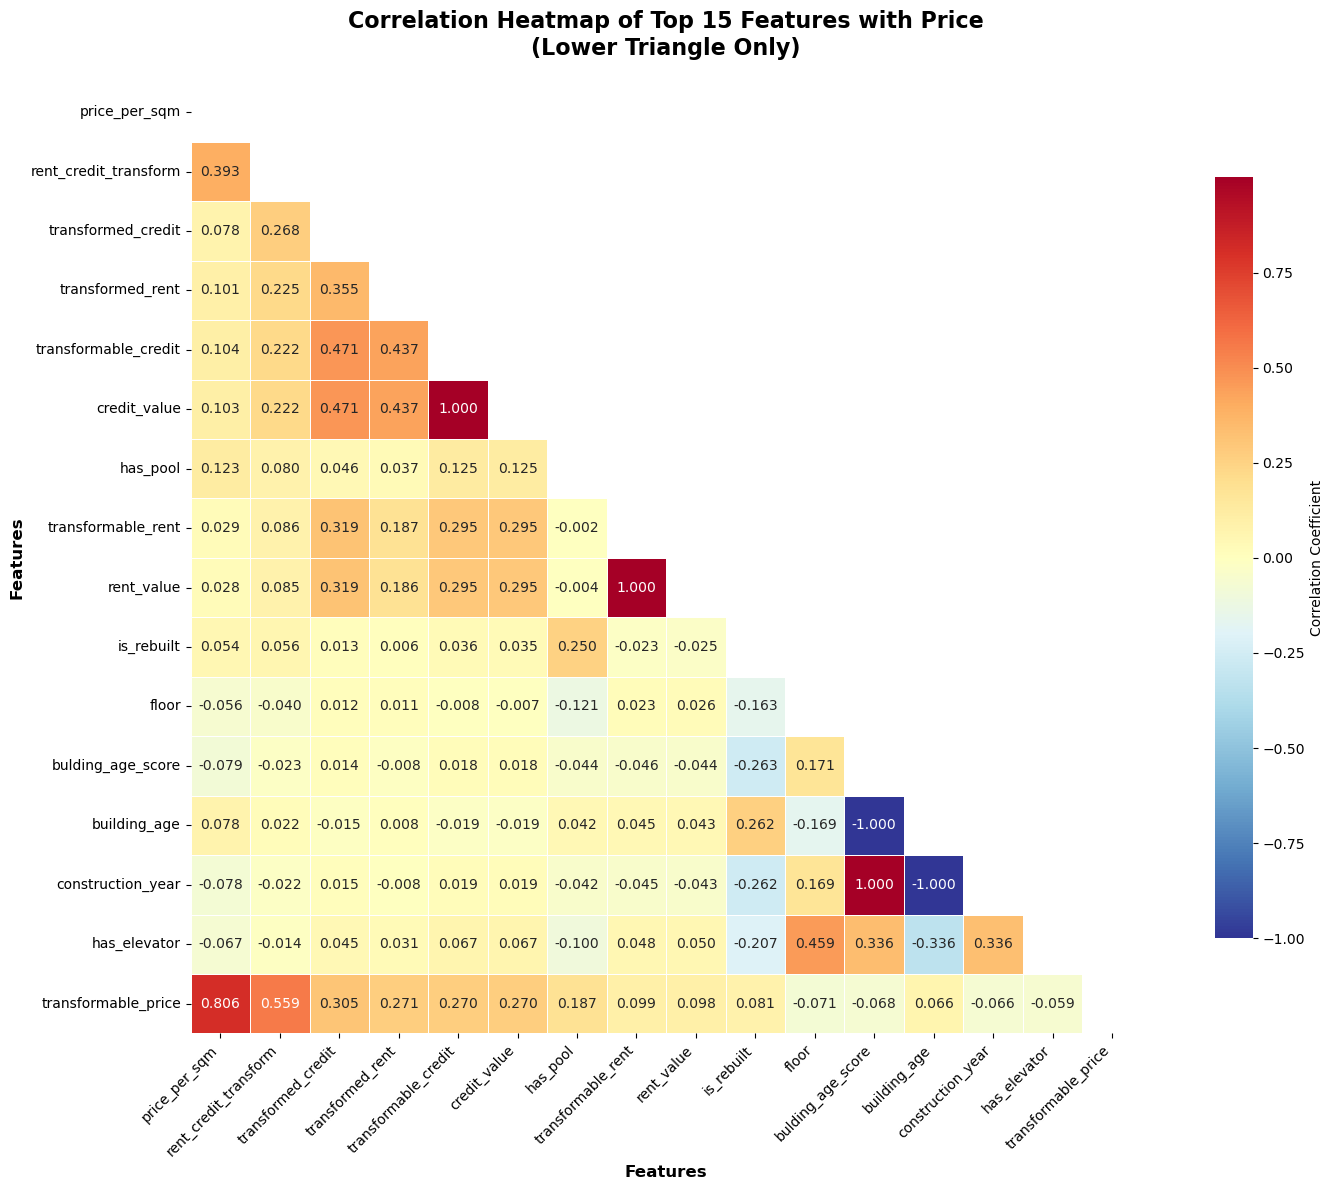


--- Feature Importance Analysis ---
Top 15 Features by Random Forest Importance:
   1. price_per_sqm: 0.9976
   2. transformed_rent: 0.0011
   3. transformed_credit: 0.0009
   4. building_size: 0.0004
   5. rent_credit_transform: 0.0000
   6. has_business_deed: 0.0000
   7. unit_per_floor: 0.0000
   8. regular_person_capacity: 0.0000
   9. has_balcony: 0.0000
  10. transformable_credit: 0.0000
  11. amenity_score: 0.0000
  12. location_latitude: 0.0000
  13. location_radius: 0.0000
  14. location_longitude: 0.0000
  15. price_value: 0.0000


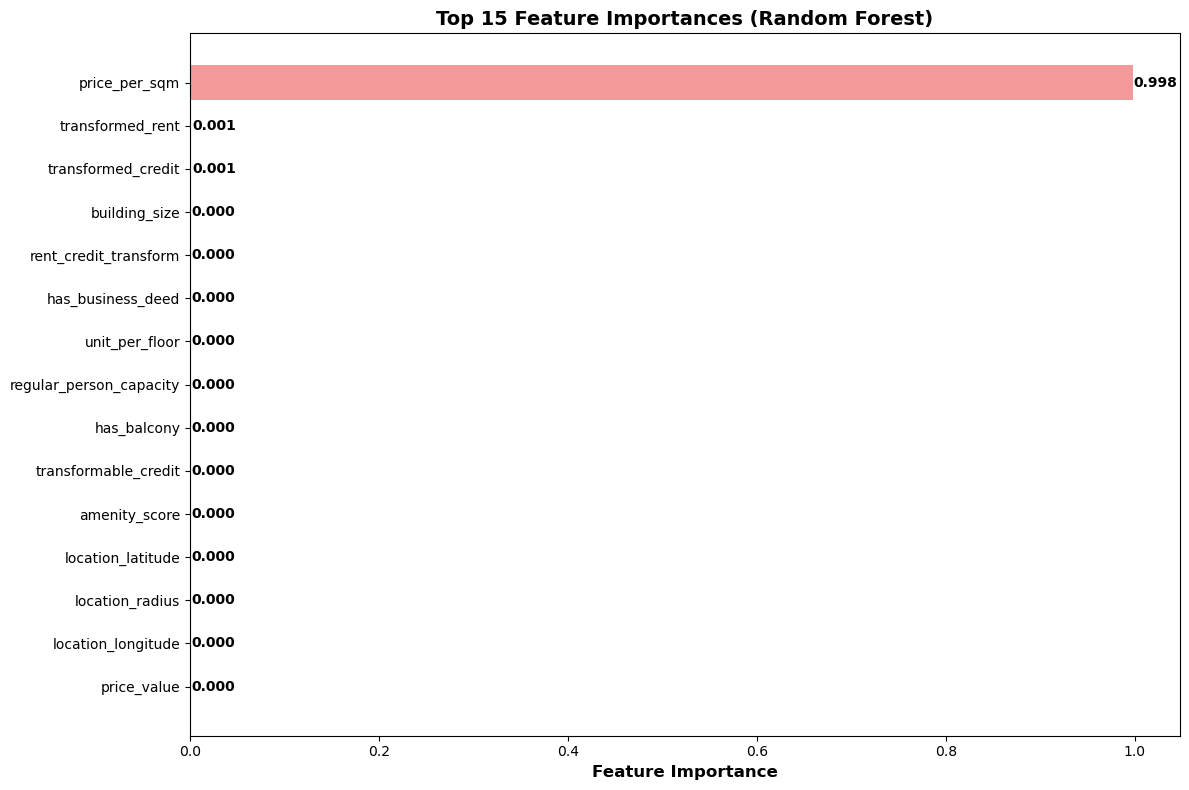

In [46]:

print("\n=== Correlation Analysis ===")

# Select numerical columns for correlation analysis
numerical_cols = df_filterd.select_dtypes(include=[np.number]).columns.tolist()
price_related_cols = [col for col in numerical_cols if 'price' in col.lower() or 'transformable' in col.lower()]

# Get top features based on correlation with target variable
target_variable = 'transformable_price'
if target_variable in df_filterd.columns:
    
    # Calculate correlations with target variable
    correlations = df_filterd[numerical_cols].corrwith(df_filterd[target_variable]).abs().sort_values(ascending=False)
    
    # Remove the target variable itself and get top features
    correlations = correlations.drop(target_variable, errors='ignore')
    top_features = correlations.head(15).index.tolist()
    
    print("Top 15 features by correlation with price:")
    for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        print(f"  {i:2d}. {feature}: {corr:.4f}")
    
    # Create correlation matrix for top features + target
    correlation_features = top_features + [target_variable]
    correlation_matrix = df_filterd[correlation_features].corr()
    
    # Create the heatmap
    plt.figure(figsize=(16, 12))
    
    # Create mask for upper triangle to show only lower triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt='.3f', 
                cmap='RdYlBu_r', 
                center=0, 
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                annot_kws={'size': 10})
    
    plt.title('Correlation Heatmap of Top 15 Features with Price\n(Lower Triangle Only)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Feature importance using Random Forest
    print("\n--- Feature Importance Analysis ---")
    
    # Prepare data for feature importance
    feature_columns = [col for col in numerical_cols if col != target_variable]
    X_importance = df_filterd[feature_columns].fillna(df_filterd[feature_columns].median())
    y_importance = df_filterd[target_variable].fillna(df_filterd[target_variable].median())
    
    # Train Random Forest for feature importance
    rf_importance = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_importance.fit(X_importance, y_importance)
    
    # Get feature importances
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_importance.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Features by Random Forest Importance:")
    for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
        print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # Feature importance plot
    plt.figure(figsize=(12, 8))
    top_15_importance = importance_df.head(15)
    
    bars = plt.barh(range(len(top_15_importance)), top_15_importance['importance'], 
                   color='lightcoral', alpha=0.8)
    plt.yticks(range(len(top_15_importance)), top_15_importance['feature'])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# =============================================================================
# STEP 10: FINAL VALIDATION AND EXPORT
# =============================================================================

In [47]:

print("\n=== Final Data Quality Report ===")

# Check for missing values after imputation
missing_after = df_filterd.isnull().sum()
missing_percentage_after = (missing_after / len(df_filterd) * 100).round(2)

missing_summary_after = pd.DataFrame({
    'Missing_Count': missing_after,
    'Missing_Percentage': missing_percentage_after
})

columns_with_missing = missing_summary_after[missing_summary_after['Missing_Count'] > 0]

print(f"Dataset shape: {df_filterd.shape}")
print(f"Total missing values: {missing_after.sum()}")
print(f"Columns with missing values: {len(columns_with_missing)}")

if len(columns_with_missing) > 0:
    print("\nRemaining columns with missing values:")
    print(columns_with_missing.sort_values('Missing_Percentage', ascending=False))
else:
    print("✓ No missing values remaining!")

# Data types summary
print(f"\nData types summary:")
print(df_filterd.dtypes.value_counts())


=== Final Data Quality Report ===
Dataset shape: (649678, 65)
Total missing values: 410265
Columns with missing values: 1

Remaining columns with missing values:
                 Missing_Count  Missing_Percentage
location_radius         410265               63.15

Data types summary:
object     18
Int8       18
float32    16
float64    11
Int16       1
int16       1
Name: count, dtype: int64


In [48]:
print(f"\nTop Features by Type:")
price_features = [col for col in df.columns if 'price' in col.lower() or 'rent' in col.lower()]
size_features = [col for col in df.columns if 'size' in col.lower() or 'area' in col.lower()]
location_features = [col for col in df.columns if any(x in col.lower() for x in ['city', 'neighborhood', 'location'])]
amenity_features = [col for col in df.columns if 'has_' in col.lower() or 'score' in col.lower()]

print(f"  Price-related: {len(price_features)} features")
print(f"  Size-related: {len(size_features)} features")
print(f"  Location-related: {len(location_features)} features")
print(f"  Amenity-related: {len(amenity_features)} features")


Top Features by Type:
  Price-related: 13 features
  Size-related: 2 features
  Location-related: 8 features
  Amenity-related: 17 features


In [49]:
print(f"\nReady for Machine Learning:")
print(f"  ✓ No missing values")
print(f"  ✓ Optimized data types")
print(f"  ✓ Scaled numerical features")
print(f"  ✓ Encoded categorical features")
print(f"  ✓ Rich feature set for real estate prediction")
print(f"  ✓ Preprocessing artifacts saved for production use")


Ready for Machine Learning:
  ✓ No missing values
  ✓ Optimized data types
  ✓ Scaled numerical features
  ✓ Encoded categorical features
  ✓ Rich feature set for real estate prediction
  ✓ Preprocessing artifacts saved for production use
